In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import cupy as cp

In [5]:
PROJECT_PATH = '../'
BLUE_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_Blue_R2300.h5"
NIR_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_NIR_R4300.h5"
sys.path.insert(0, PROJECT_PATH)

In [61]:
def collect_flux(nSample=10000, Rs=None):
    fluxs=[]
    pvals=[]
    lbls =[]
    if Rs is None: Rs = ["M31G", "MWW", "MWC", "BHB", "RHB"]
    for ii, R in enumerate(Rs):
        RBF_PATH = f"/scratch/ceph/swei20/data/dnn/{R}/rbf_RMLL_R500_10k.h5"
        with h5py.File(RBF_PATH, 'r') as f:
            flux0 = f['normflux'][()]
            pval0 = f['pval'][()]
            wave0 = f['wave'][()]
        fluxs.append(flux0[:nSample])
        pvals.append(pval0[:nSample])
        lbls.append(np.zeros(len(flux0)) + ii)
    fluxs = np.vstack(fluxs)
    pvals = np.vstack(pvals)
    lbls = np.hstack(lbls)
    lbln = [Rs[int(lbls[i])] for i in range(len(lbls))]    
    print(fluxs.shape, pvals.shape, lbls.shape)
    return fluxs, pvals, lbls, lbln, wave0

In [62]:
fluxs, pvals, lbls, lbln, wave0 = collect_flux()

(50000, 2204) (50000, 5) (50000,)


In [63]:
from lv.base.dataloader_c import DataLoader

In [64]:
ds = DataLoader()

In [65]:
ds.prepare_data_custom("RMLL", fluxs, wave0, pvals, lbl=lbln)

(50000, 2204) (2204,) (50000, 5)


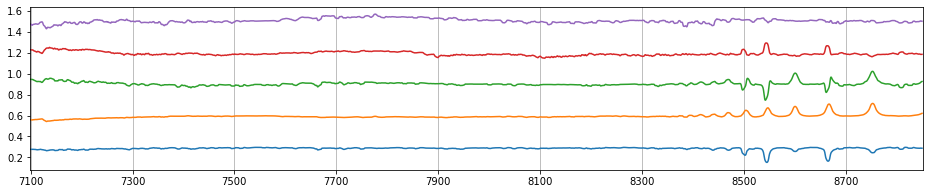

In [66]:
ds.init_pcp()

# Get informative lines

In [67]:
ds.prepare_lines()

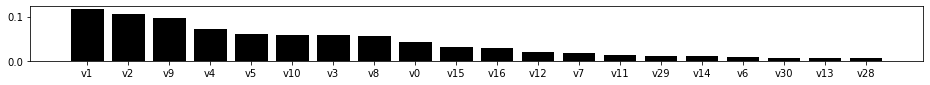

In [68]:
ds.get_X_cluster(data = 1)

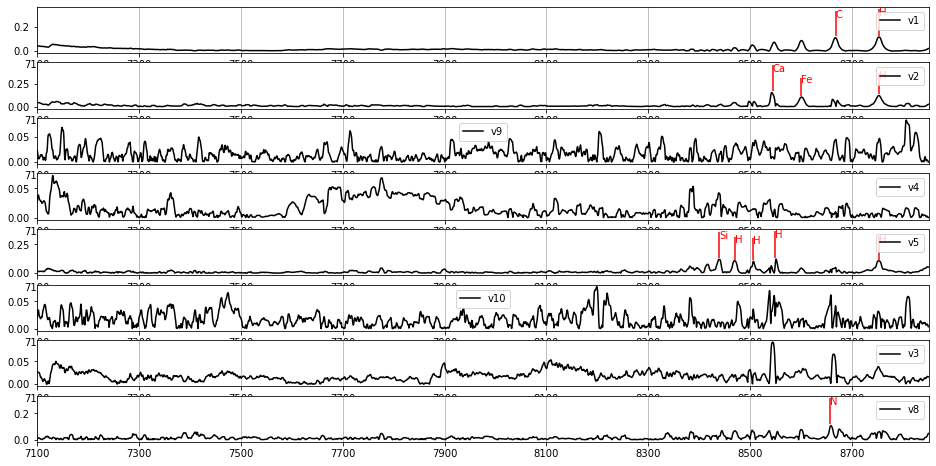

In [93]:
ds.plot_XdxAll(pcp=0, top=4, rfr=0)

In [94]:
FluxC = ds.pcaFlux[:, ds.Cadx]

In [95]:
from cuml import UMAP

In [105]:
umap_dim = 5
u = UMAP(n_neighbors=1000, n_components=umap_dim)

In [106]:
uu = u.fit_transform(FluxC)

In [107]:
nuu = cp.asnumpy(uu)

In [108]:
dfumap = pd.DataFrame(data=nuu, columns = [f"u{i}" for i in range(umap_dim)])

In [109]:
# lbln = [RRs[int(lbls[i])] for i in range(len(lbls))]

In [110]:
dfumap["lbl"]=lbln

In [111]:
dfumap["lbl"].unique()

array(['M31G', 'MWW', 'MWC', 'BHB', 'RHB'], dtype=object)

In [112]:
import seaborn as sns

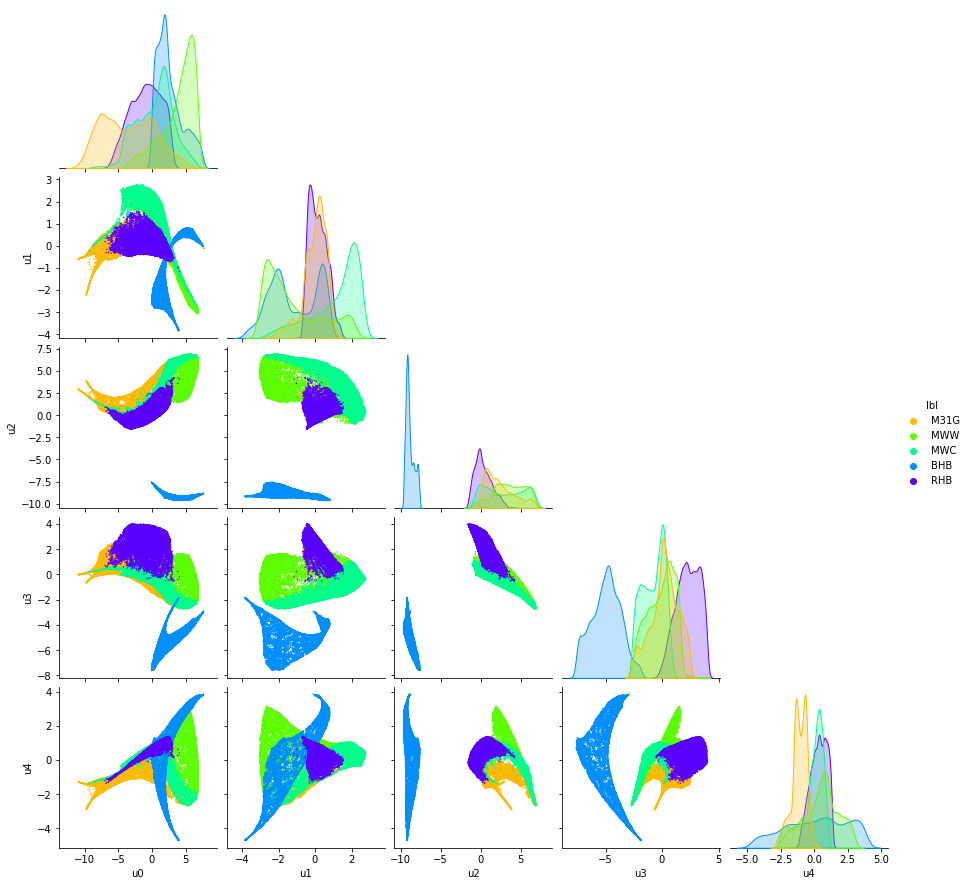

In [113]:
sns.pairplot(
    dfumap,
    x_vars = [f"u{i}" for i in range(umap_dim)],
    y_vars = [f"u{i}" for i in range(umap_dim)],
    hue = "lbl",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=None,
    palette="gist_rainbow",
    corner=True
)

In [114]:
from lv.base.dataloader_c import DataLoader

In [115]:
ds = DataLoader()

In [116]:
ds.prepare_data_custom("RedM", fluxs, wave0, pvals, lbl=lbln)

(50000, 2204) (2204,) (50000, 5)


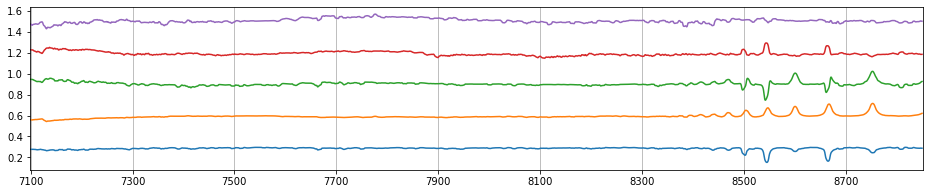

In [117]:
ds.init_pcp()

In [121]:
k,q,prom = 10, 0.75, 0.01
# k,q,prom = 5, 0.7,0.02
peaks, prop, nvv= ds.get_peaks(k=k,q=q,prom=prom)

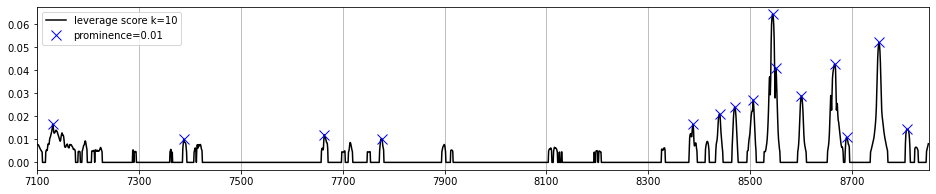

In [122]:
ds.plot_peaks(nvv, peaks, k, prom)

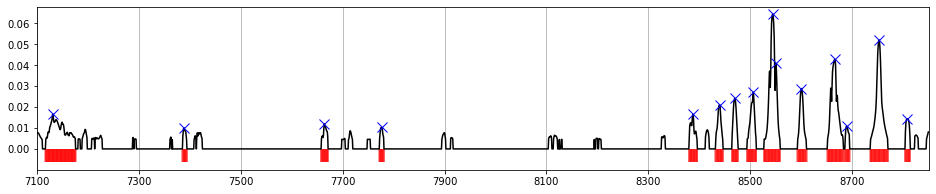

In [123]:
ds.plot_mask_from_peaks(peaks, prop, nvv)

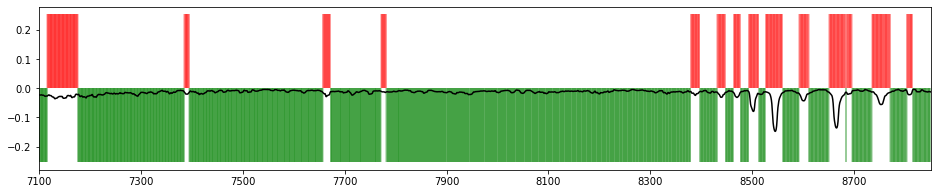

In [124]:
ds.plot_MN_mask(0)

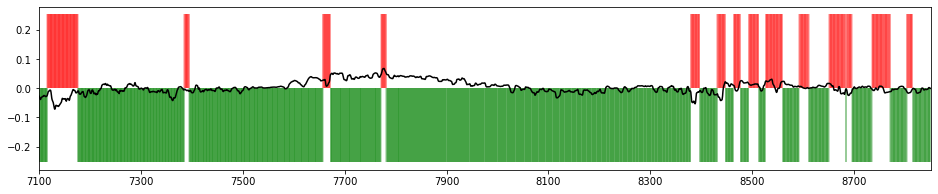

In [125]:
ds.plot_MN_mask(4)

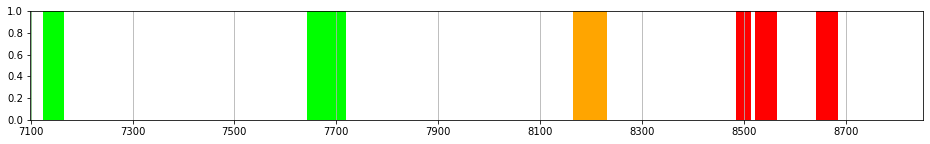

In [126]:
ds.plot_lick()

In [127]:
ds.get_MN(ds.nmask, top=5)

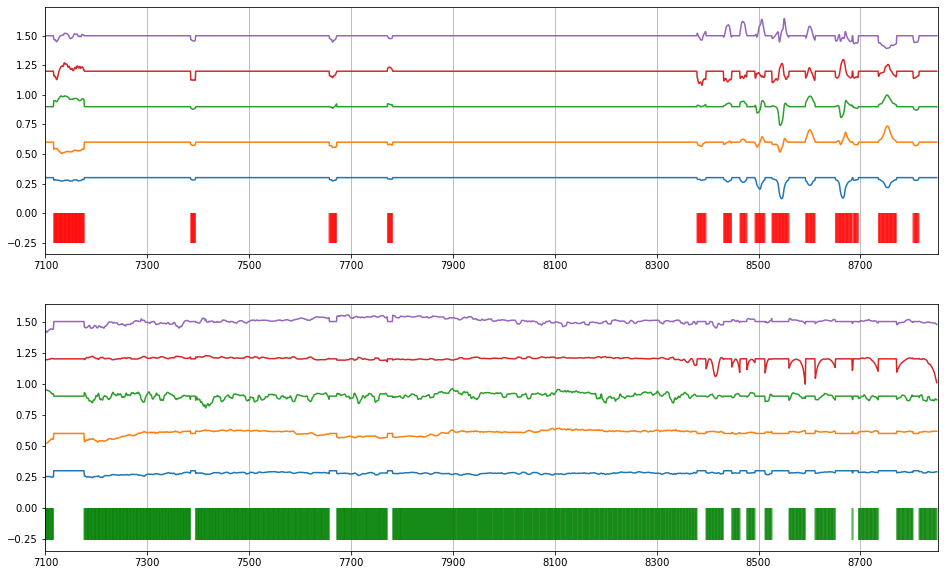

In [128]:
ds.plot_MN(step=0.3)

In [129]:
mu = 1.0 / ds.Mw[2]
ML, MS, MLv, MSv = ds._pcp(ds.M, delta=1e-5, mu=mu, lam=None, norm=None, maxiter=1000)

mu 0.01, lambda 0.0045, norm 200043.6


L(43, 373), S(30, 373)


(43, 2204)


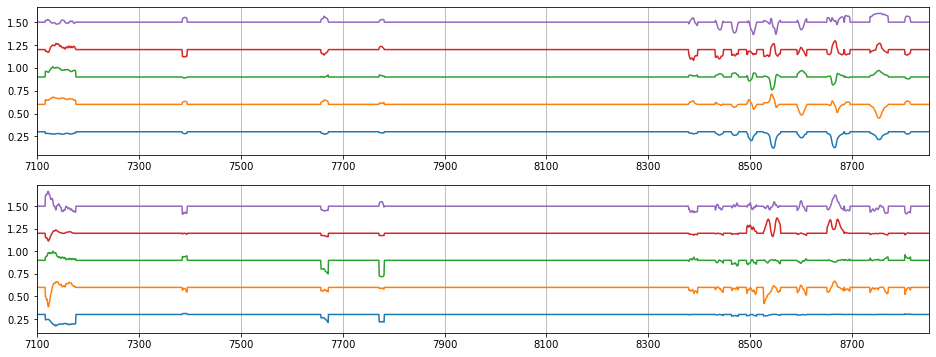

In [130]:
nMLv, nMSv =ds.eval_pcp(MLv, MSv)

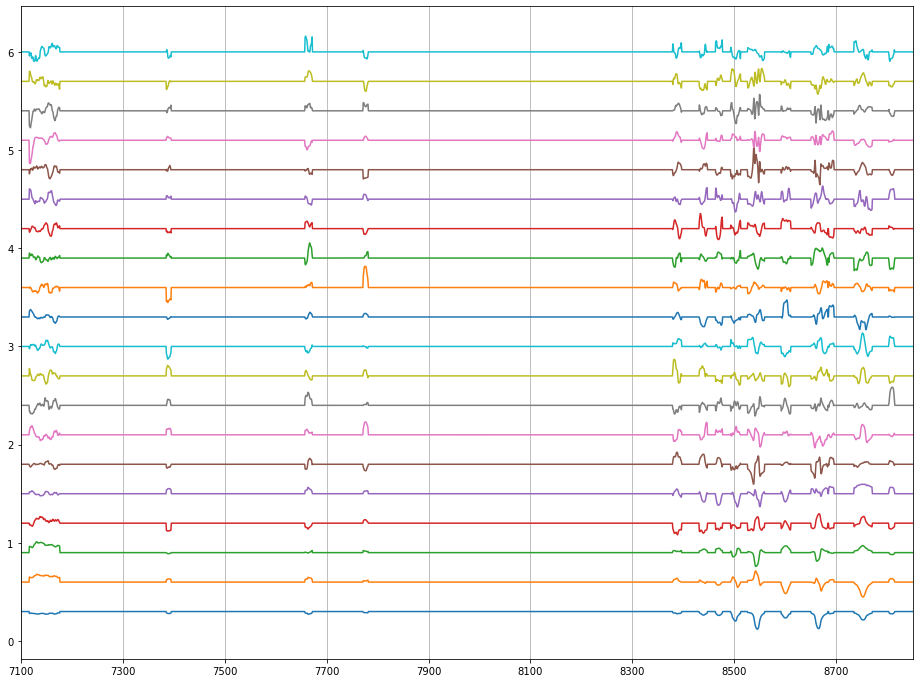

In [131]:
ds.plot_V(nMLv, top=20)

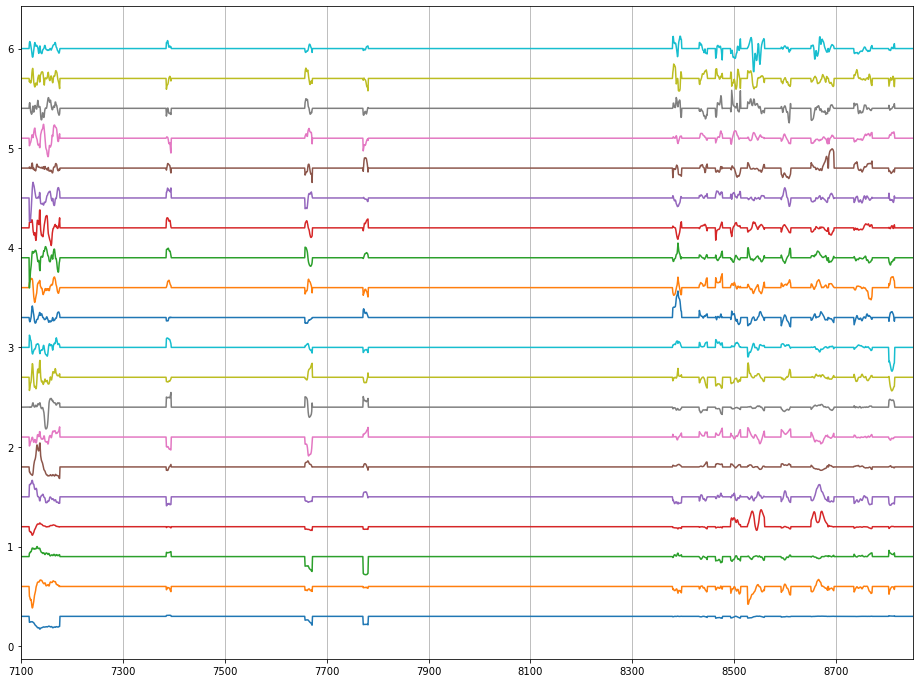

In [132]:
ds.plot_V(nMSv, top=20)

In [133]:
mu = 1.0 / ds.Nw[2]
NL, NS, NLv, NSv = ds._pcp(ds.N, delta=1e-6, mu=mu, lam=None, norm=None, maxiter=100)

mu 0.02, lambda 0.0045, norm 105582.1


L(41, 1831), S(30, 1831)


(41, 2204)


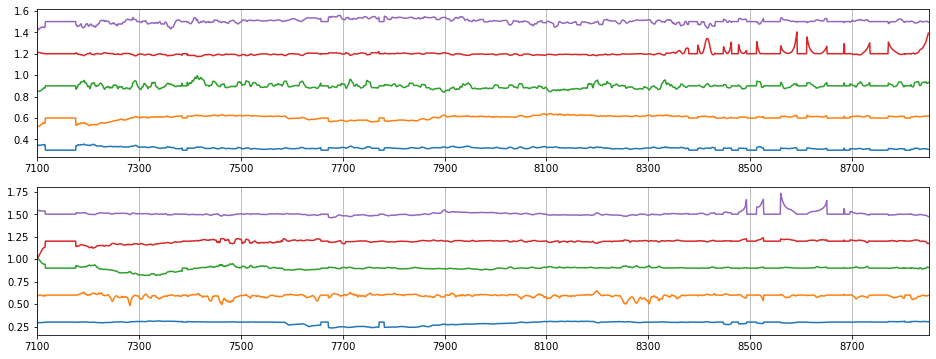

In [134]:
nNLv, nNSv = ds.eval_pcp(NLv, NSv, isM=0)

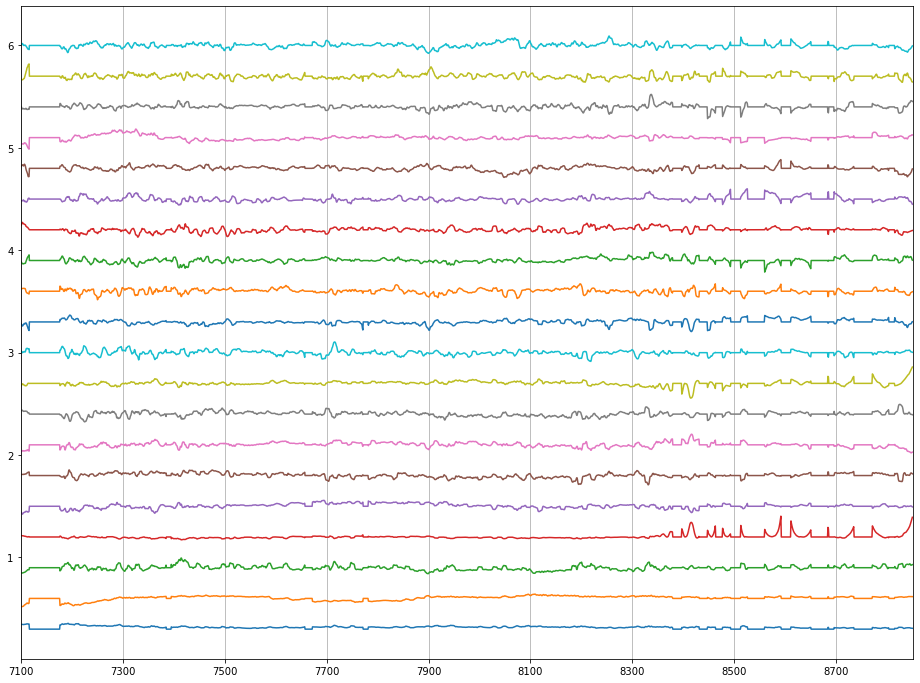

In [135]:
ds.plot_V(nNLv, top=20)

In [136]:
ds.pcp_transform(MLv, MSv, NLv, NSv, top=20)

In [137]:
PATH="/scratch/ceph/swei20/data/dnn/ALL/bosz_pcp_rbf10k.h5"

In [139]:
ds.pcp_np(save=0, PATH=PATH)

# Get informative lines

In [140]:
ds.prepare_lines()

In [141]:
ds.Cdx={}
ds.CdxAll = None

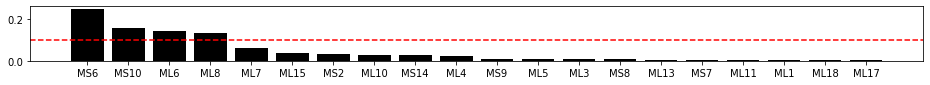

In [142]:
ds.get_X_cluster(X="M")

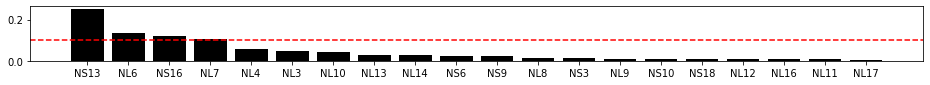

In [143]:
ds.get_X_cluster(X="N")

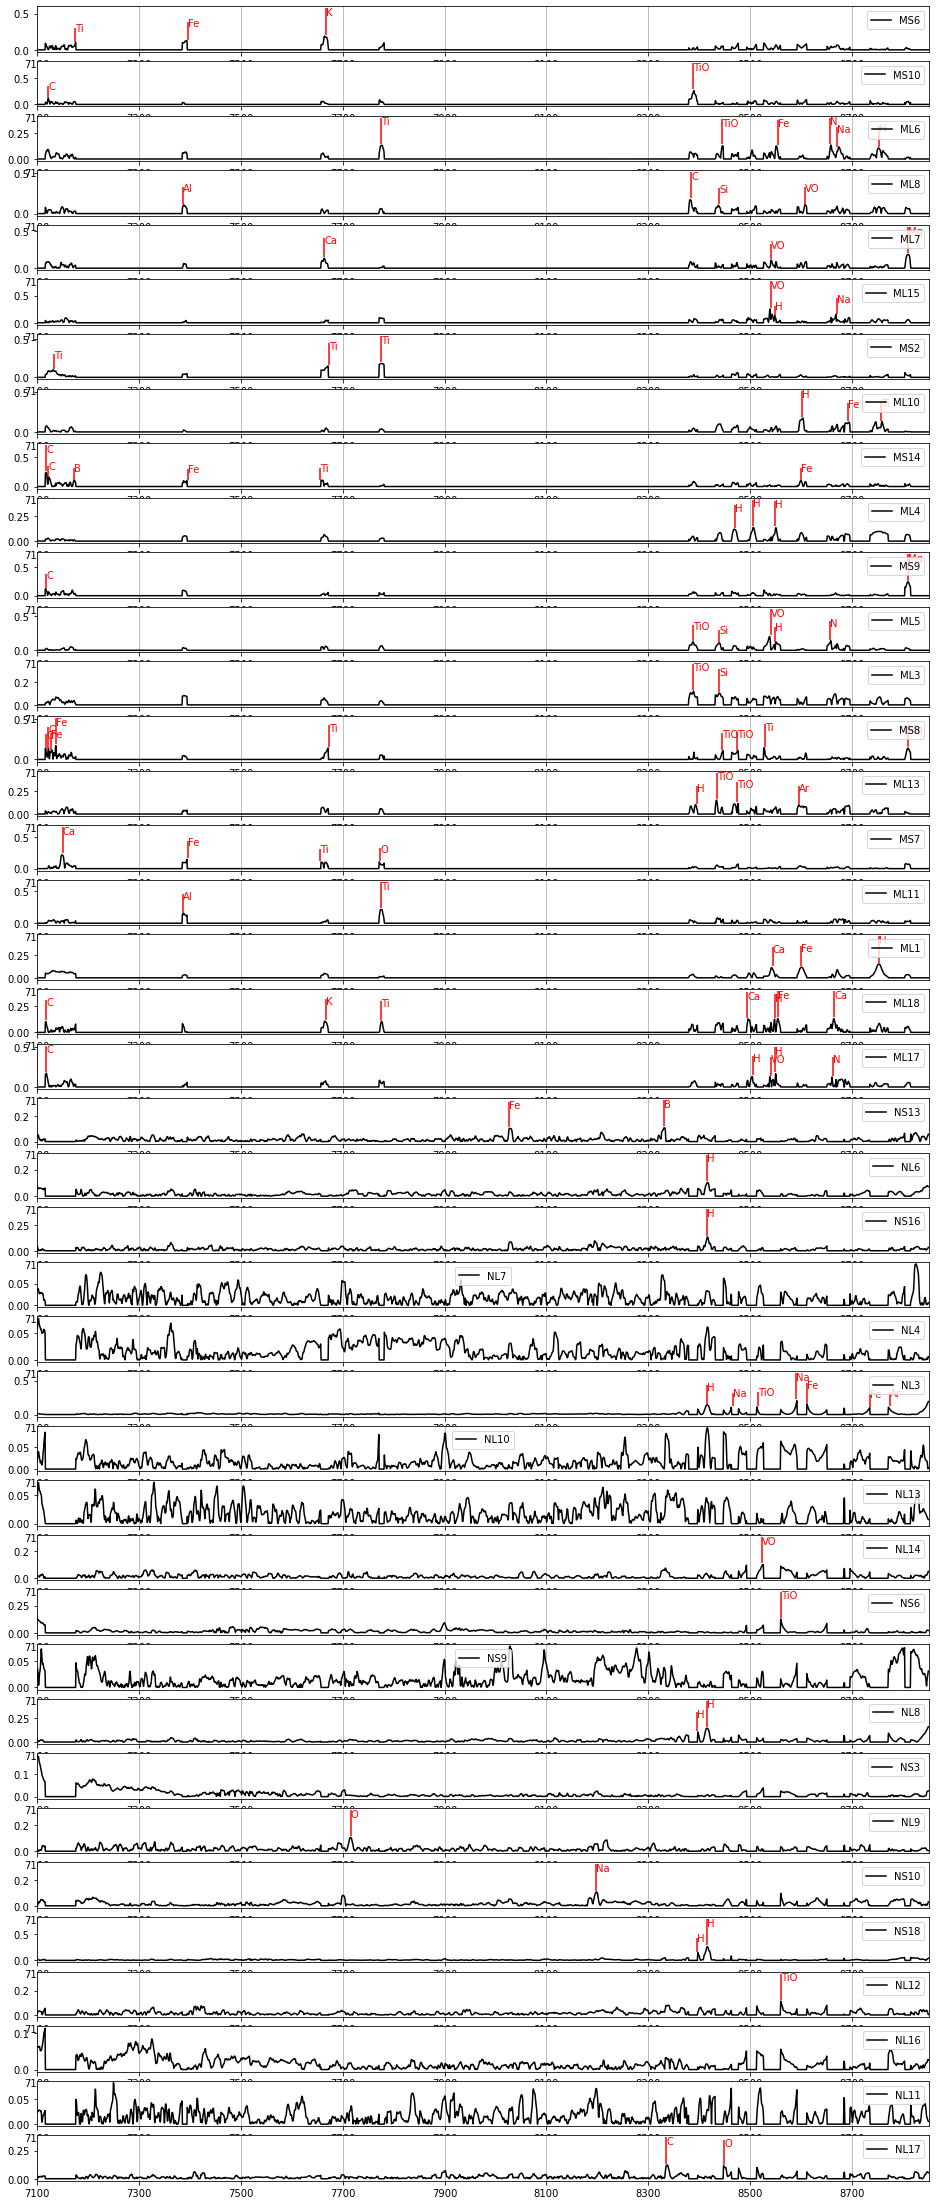

In [144]:
ds.plot_XdxAll(top=20, rfr=0)

In [145]:
ds.CdxAll.shape

(40,)

In [ ]:
ds.p

In [146]:
nFluxC = ds.npcpFlux[:, ds.CdxAll]

In [147]:
FluxC = ds.pcpFlux[:, ds.CdxAll]

In [148]:
FluxC.shape

(50000, 40)

In [149]:
from cuml import UMAP

In [150]:
umap_dim = 5
u = UMAP(n_neighbors=500, n_components=umap_dim)

In [151]:
uu = u.fit_transform(FluxC)

In [152]:
nuu = cp.asnumpy(uu)

In [153]:
dfumap = pd.DataFrame(data=nuu, columns = [f"u{i}" for i in range(umap_dim)])

In [154]:
# lbln = [RRs[int(lbls[i])] for i in range(len(lbls))]

In [155]:
dfumap["lbl"]=lbln

In [156]:
dfumap["lbl"].unique()

array(['M31G', 'MWW', 'MWC', 'BHB', 'RHB'], dtype=object)

In [157]:
import seaborn as sns

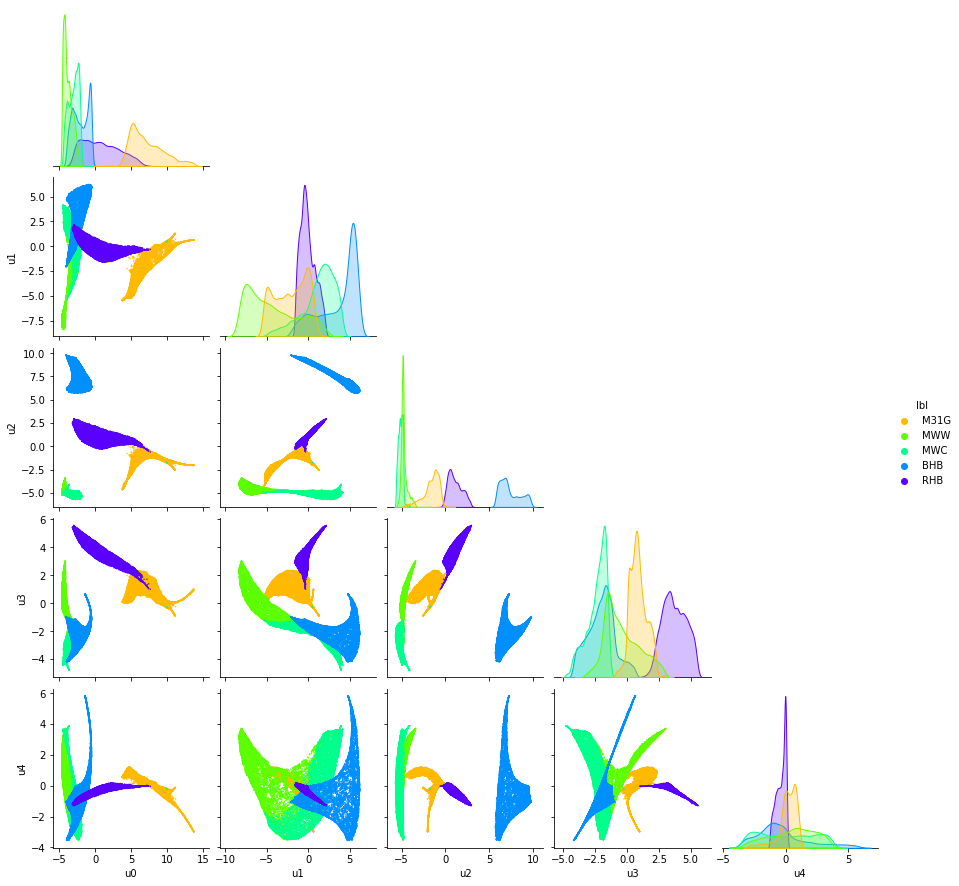

In [158]:
sns.pairplot(
    dfumap,
    x_vars = [f"u{i}" for i in range(umap_dim)],
    y_vars = [f"u{i}" for i in range(umap_dim)],
    hue = "lbl",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=None,
    palette="gist_rainbow",
    corner=True
)

<AxesSubplot:xlabel='u0', ylabel='u2'>

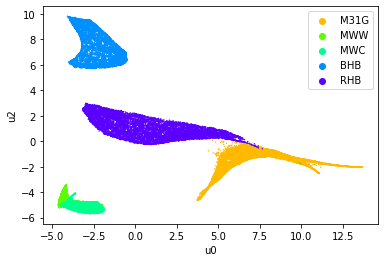

In [159]:
sns.scatterplot(data=dfumap, x="u0", y="u2",marker="o", s=2, edgecolor="none", hue=lbln, palette="gist_rainbow")

<AxesSubplot:xlabel='u1', ylabel='u2'>

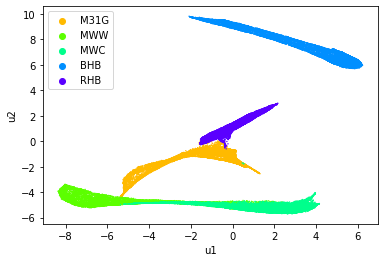

In [160]:
sns.scatterplot(data=dfumap, x="u1", y="u2",marker="o", s=2, edgecolor="none", hue=lbln, palette="gist_rainbow")
